In [975]:
import pandas as pd
from matplotlib import pyplot as plt
import datetime
from datetime import timedelta
from datetime import datetime

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np
from numpy import NaN

In [858]:
CURRENT_LOCATION = "bolz"

In [951]:
path_to_file = 'APPA_data_merged.csv'
df = pd.read_csv(path_to_file, parse_dates=["Data"])
df_bolz_pm10 = df[(df.Stazione == "Via Bolzano") & (df.Inquinante == "PM10")]

In [962]:
station_list = df.Stazione.unique()
pollutants_per_station = {}
for st in station_list:
    pollutants_per_station[st] = df[df.Stazione == st].Inquinante.unique().tolist()

pollutants_per_station

{'A22 (Avio)': ['Biossido di Azoto', 'Ossido di Carbonio', 'PM10'],
 'Borgo Valsugana': ['Biossido di Azoto', 'Ozono', 'PM10', 'PM2.5'],
 'Monte Gaza': ['Biossido di Azoto', 'Ozono', 'PM10'],
 'Parco S. Chiara': ['Biossido Zolfo',
  'Biossido di Azoto',
  'Ozono',
  'PM10',
  'PM2.5'],
 'Piana Rotaliana': ['Biossido di Azoto', 'Ozono', 'PM10'],
 'Riva del Garda': ['Biossido di Azoto', 'Ozono', 'PM10'],
 'Rovereto': ['Biossido di Azoto', 'Ozono', 'PM10', 'PM2.5'],
 'Via Bolzano': ['Biossido di Azoto', 'Ossido di Carbonio', 'PM10']}

In [972]:
def get_daily(station, polutant):
    to_return = df[(df.Stazione == station) & (df.Inquinante == polutant)]
    return to_return.resample('D', on="Data").mean()

In [973]:
Bolzano_PM10 = get_daily("Via Bolzano", "PM10")

,Valore
Data,
2012-01-01,55.727273
2012-01-02,62.291667
2012-01-03,36.708333
2012-01-04,33.041667
2012-01-05,26.375000
...,...
2022-07-04,16.250000
2022-07-05,9.291667
2022-07-06,9.875000


In [ ]:
def plot_st_pol(station, pollutant):
    pass


In [968]:
d = {"Data" : []}
daily_mean_per_station_and_pollutant = pd.DataFrame()

for st in station_list:
    for poll in pollutants_per_station[st]:
        data = df[(df.Stazione == st) & (df.Inquinante == poll)]
        data = data.resample("D", on='Data').mean()
        daily_mean_per_station_and_pollutant[st + "_" + poll] = data.Valore



               Valore
Data                 
2017-01-01  86.086957
2017-01-02  97.875000
2017-01-03  66.875000
2017-01-04  76.708333
2017-01-05  55.166667
...               ...
2022-07-04  28.833333
2022-07-05  23.458333
2022-07-06  28.041667
2022-07-07  26.958333
2022-07-08  17.000000

[2015 rows x 1 columns]
              Valore
Data                
2017-01-01  0.978261
2017-01-02  1.054167
2017-01-03  0.937500
2017-01-04  1.000000
2017-01-05  0.775000
...              ...
2022-07-04  0.308333
2022-07-05  0.308333
2022-07-06  0.312500
2022-07-07  0.304167
2022-07-08  0.300000

[2015 rows x 1 columns]
               Valore
Data                 
2017-01-01  22.304348
2017-01-02  30.500000
2017-01-03  22.916667
2017-01-04  19.541667
2017-01-05  15.291667
...               ...
2022-07-04  14.625000
2022-07-05   9.750000
2022-07-06  11.000000
2022-07-07  12.541667
2022-07-08  13.000000

[2015 rows x 1 columns]
               Valore
Data                 
2012-01-01  36.608696
2012-01-02  40

KeyboardInterrupt: 

Makes the daily mean from the hour values

In [859]:
df_daily = df_bolz_pm10.resample("D", on='Data').mean()
df_daily = df_daily.reset_index()

In [860]:
df_daily.head()

,Data,Valore
0,2012-01-01,55.727273
1,2012-01-02,62.291667
2,2012-01-03,36.708333
3,2012-01-04,33.041667
4,2012-01-05,26.375000


In [861]:
weather_file_path = "weather_data.csv"
weather_df = pd.read_csv(weather_file_path, parse_dates=["Data"])

In [862]:
locations = list(set(weather_df.columns[1:].map(lambda x: x.split()[0])))
locations

['rg', 'bolz', 'parco', 'borgo', 'piana', 'avio', 'rov', 'mgazza']

In [863]:
weather_loc = {}

for location in locations:
    location_columns = weather_df.columns[
        weather_df.columns.map(lambda x: x.split()[0] == location)
    ]

    location_df = weather_df[["Data"] + location_columns.tolist()]
    location_df.columns = location_df.columns.str.replace(location, "").str.strip()
    location_df["Location"] = location
    
    weather_loc[location] = location_df


C:\Users\thoma\AppData\Local\Temp\ipykernel_3592\2564517573.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_df["Location"] = location
C:\Users\thoma\AppData\Local\Temp\ipykernel_3592\2564517573.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_df["Location"] = location
C:\Users\thoma\AppData\Local\Temp\ipykernel_3592\2564517573.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [864]:
df_weather_long = pd.concat(weather_loc.values())
# df_weather_long.to_csv("./weather_long_format.csv", index=None)

In [865]:
merged_df = df_daily.join(
    df_weather_long[df_weather_long.Location == CURRENT_LOCATION].set_index("Data"), 
    on="Data"
)
merged_df

,Data,Valore,rain,temp,Location,hum,w_dir,w_sp,press,sol
0,2012-01-01,55.727273,0.0,0.0,bolz,78.6,342.0,0.7,995.5,6433.5
1,2012-01-02,62.291667,15.0,-0.4,bolz,95.0,348.0,1.0,994.7,1154.3
2,2012-01-03,36.708333,0.6,3.6,bolz,86.8,329.0,1.8,997.5,7082.0
3,2012-01-04,33.041667,0.0,0.1,bolz,90.0,337.0,1.0,993.7,3149.2
4,2012-01-05,26.375000,0.0,1.0,bolz,79.8,343.0,1.5,980.3,5839.9
...,...,...,...,...,...,...,...,...,...,...
3837,2022-07-04,16.250000,7.0,23.2,bolz,70.6,315.0,3.7,991.4,16440.8
3838,2022-07-05,9.291667,0.0,24.9,bolz,59.5,330.0,2.9,989.0,25228.8
3839,2022-07-06,9.875000,0.0,25.2,bolz,54.2,336.0,2.0,990.8,28751.0
3840,2022-07-07,14.875000,4.0,23.5,bolz,62.2,296.0,1.3,989.6,19994.8


In [976]:
# add column for the value of the previous day
weather_parameters = ['rain', 'temp', 'press', 'hum', 'w_dir', 'w_sp', 'sol']
prev_day_values = {}
for par in weather_parameters:
    for i in range(1, 8):
        prev_day_values[f"{par} {i} day/s earlier"]  = []
        for date in merged_df["Data"]:
            prev_day = date - timedelta(hours=int(24 * i))
            series = merged_df[merged_df.Data == prev_day][par].values.tolist()
            #print(series)
            if len(series) > 0:
                value = series[0]
            else:
                value = NaN  # takes the current day, not the previous
            prev_day_values[f"{par} {i} day/s earlier"].append(value)

        merged_df[f"{par} {i} day/s earlier"] = prev_day_values[f'{par} {i} day/s earlier']

C:\Users\thoma\AppData\Local\Temp\ipykernel_3592\2101953432.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df[f"{par} {i} day/s earlier"] = prev_day_values[f'{par} {i} day/s earlier']
C:\Users\thoma\AppData\Local\Temp\ipykernel_3592\2101953432.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df[f"{par} {i} day/s earlier"] = prev_day_values[f'{par} {i} day/s earlier']
C:\Users\thoma\AppData\Local\Temp\ipykernel_3592\2101953432.py:17: SettingWithCopyWarning: 
A value is trying to be se

In [999]:
merged_df = merged_df.dropna()

In [867]:
merged_df.isna().sum()

Data         0
Valore      13
rain         5
temp         5
Location     0
hum          3
w_dir        3
w_sp         4
press        3
sol          4
Prev day    13
dtype: int64

In [868]:
merged_df.corr()

,Valore,rain,temp,hum,w_dir,w_sp,press,sol,Prev day
Valore,1.000000,-0.122648,-0.444380,0.274519,0.004813,-0.486611,0.297860,-0.391982,0.734838
rain,-0.122648,1.000000,0.016624,0.373602,0.027997,-0.001040,-0.321844,-0.245043,-0.017086
temp,-0.444380,0.016624,1.000000,-0.251255,-0.096029,0.401969,-0.147064,0.733091,-0.424701
hum,0.274519,0.373602,-0.251255,1.000000,0.104384,-0.648380,-0.133332,-0.596991,0.258585
w_dir,0.004813,0.027997,-0.096029,0.104384,1.000000,-0.129086,0.102721,-0.053515,0.007373
w_sp,-0.486611,-0.001040,0.401969,-0.648380,-0.129086,1.000000,-0.231920,0.492839,-0.311340
press,0.297860,-0.321844,-0.147064,-0.133332,0.102721,-0.231920,1.000000,0.052634,0.178568
sol,-0.391982,-0.245043,0.733091,-0.596991,-0.053515,0.492839,0.052634,1.000000,-0.416035
Prev day,0.734838,-0.017086,-0.424701,0.258585,0.007373,-0.311340,0.178568,-0.416035,1.000000


In [869]:
merged_df.describe()

,Valore,rain,temp,hum,w_dir,w_sp,press,sol,Prev day
count,3829.000000,3837.000000,3837.000000,3839.000000,3839.000000,3838.000000,3839.000000,3838.000000,3829.000000
mean,24.245645,2.794423,12.800469,70.803204,299.088304,1.738093,989.457333,13425.558494,24.256542
std,14.101629,7.923554,8.031611,15.276657,68.967493,0.802883,7.334207,8128.025217,14.109830
min,0.000000,0.000000,-6.300000,18.600000,0.000000,0.000000,952.700000,0.000000,0.000000
25%,14.291667,0.000000,5.900000,60.300000,294.500000,1.100000,985.200000,6420.425000,14.291667
50%,21.333333,0.000000,13.100000,71.400000,324.000000,1.700000,989.400000,12330.800000,21.363636
75%,30.958333,0.800000,19.800000,82.550000,338.000000,2.200000,993.700000,20257.000000,30.958333
max,156.125000,97.000000,29.600000,100.000000,360.000000,6.700000,1014.900000,31686.900000,156.125000


In [870]:
merged_df = merged_df.dropna()
merged_df

,Data,Valore,rain,temp,Location,hum,w_dir,w_sp,press,sol,Prev day
0,2012-01-01,55.727273,0.0,0.0,bolz,78.6,342.0,0.7,995.5,6433.5,55.727273
1,2012-01-02,62.291667,15.0,-0.4,bolz,95.0,348.0,1.0,994.7,1154.3,55.727273
2,2012-01-03,36.708333,0.6,3.6,bolz,86.8,329.0,1.8,997.5,7082.0,62.291667
3,2012-01-04,33.041667,0.0,0.1,bolz,90.0,337.0,1.0,993.7,3149.2,36.708333
4,2012-01-05,26.375000,0.0,1.0,bolz,79.8,343.0,1.5,980.3,5839.9,33.041667
...,...,...,...,...,...,...,...,...,...,...,...
3837,2022-07-04,16.250000,7.0,23.2,bolz,70.6,315.0,3.7,991.4,16440.8,23.000000
3838,2022-07-05,9.291667,0.0,24.9,bolz,59.5,330.0,2.9,989.0,25228.8,16.250000
3839,2022-07-06,9.875000,0.0,25.2,bolz,54.2,336.0,2.0,990.8,28751.0,9.291667
3840,2022-07-07,14.875000,4.0,23.5,bolz,62.2,296.0,1.3,989.6,19994.8,9.875000


In [871]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
SEED = 42

In [1000]:
input_columns = [
    'rain', 
    'temp', 
    'hum', 
    'w_dir', 
    'w_sp', 
    'press', 
    'sol',
    #'Prev day'
]

for i in range (1, 8):
    for par in weather_parameters:
        input_columns.append(f"{par} {i} day/s earlier")

X = merged_df[input_columns]
y = merged_df['Valore']

In [1001]:
test_years = [2015, 2017]
train_years = [2012, 2013, 2014, 2016, 2018, 2019, 2020, 2021, 2022]




In [1002]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, 
#                                                     test_size=0.2, 
#                                                     random_state=SEED)

In [1003]:
X_train, y_train, X_test, y_test = (
    X[merged_df.Data.dt.year.isin(train_years)],
    y[merged_df.Data.dt.year.isin(train_years)],
    X[merged_df.Data.dt.year.isin(test_years)],
    y[merged_df.Data.dt.year.isin(test_years)]
)

In [1004]:
X.shape

(3731, 56)

# ---- Start of Linear regression ----

In [877]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [878]:
regressor.intercept_

-298.3245056652635

In [879]:
regressor.coef_

array([-1.85373368e-01, -4.12057806e-01,  3.00976713e-02, -1.50454340e-02,
       -4.98894237e+00,  3.44589901e-01, -1.47538483e-04])

In [880]:
feature_names = X.columns
model_coefficients = regressor.coef_

coefficients_df = pd.DataFrame(data = model_coefficients, 
                              index = feature_names, 
                              columns = ['Coefficient value'])
print(coefficients_df)

       Coefficient value
rain           -0.185373
temp           -0.412058
hum             0.030098
w_dir          -0.015045
w_sp           -4.988942
press           0.344590
sol            -0.000148


In [881]:
feature_names = X.columns
model_coefficients = regressor.coef_

coefficients_df = pd.DataFrame(data = model_coefficients, 
                              index = feature_names, 
                              columns = ['Coefficient value'])
print(coefficients_df)

       Coefficient value
rain           -0.185373
temp           -0.412058
hum             0.030098
w_dir          -0.015045
w_sp           -4.988942
press           0.344590
sol            -0.000148


In [882]:
y_pred = regressor.predict(X_test)

In [883]:
X_test

,rain,temp,hum,w_dir,w_sp,press,sol
1096,0.0,-2.1,83.4,329.0,0.7,1007.8,6263.2
1097,0.0,0.3,80.5,325.0,0.8,1004.8,5706.2
1098,0.0,2.1,82.6,173.0,1.0,997.1,6063.6
1099,0.0,6.1,55.0,346.0,2.1,996.1,7265.4
1100,0.0,2.1,52.4,336.0,1.2,1001.6,7310.8
...,...,...,...,...,...,...,...
2187,32.8,1.1,100.0,348.0,1.1,969.6,253.2
2188,4.6,4.0,73.5,322.0,3.1,966.4,1754.1
2189,0.0,2.1,55.9,335.0,2.5,984.0,4742.2
2190,0.0,-0.3,74.5,334.0,2.1,990.2,4078.9


In [884]:
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(results)

         Actual  Predicted
1096  67.600000  42.962394
1097  45.666667  40.495868
1098  43.125000  38.400414
1099  20.500000  27.308889
1100  38.416667  35.407915
...         ...        ...
2187  37.083333  21.505115
2188   7.291667  13.829257
2189  16.666667  23.356862
2190  26.291667  29.150560
2191  42.875000  38.110380

[725 rows x 2 columns]


In [885]:
results.corr()

,Actual,Predicted
Actual,1.000000,0.581777
Predicted,0.581777,1.000000


In [886]:
test_chart_data = merged_df[
    merged_df.Data.dt.year.isin(test_years)
]

In [887]:
test_chart_data["pred"] = regressor.predict(test_chart_data[input_columns])

C:\Users\thoma\AppData\Local\Temp\ipykernel_3592\2148041345.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_chart_data["pred"] = regressor.predict(test_chart_data[input_columns])


In [888]:
input_columns

['rain', 'temp', 'hum', 'w_dir', 'w_sp', 'press', 'sol']

In [889]:
prev_val = test_chart_data.iloc[-100].Valore
predictions = [0 for i in range(100)]
for i, row in test_chart_data.iloc[-100:].iterrows():
    row_array = row[input_columns].to_numpy()


    row_array[4]+=10


    row_array[-1] = prev_val
    result = regressor.predict([row_array])[0]
    prev = result
    predictions.append(result)

c:\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature nam

In [908]:
regressor.predict([list(range(0,7))])

c:\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([23.56360669])

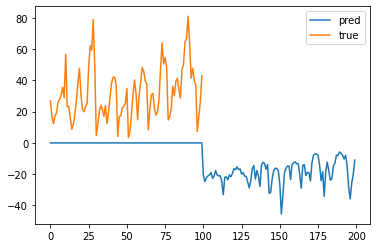

In [909]:
plt.plot(predictions, label ="pred")
plt.plot(test_chart_data.iloc[-100:].Valore.to_numpy(), label="true")
plt.legend()
plt.show()

<AxesSubplot:xlabel='Data'>

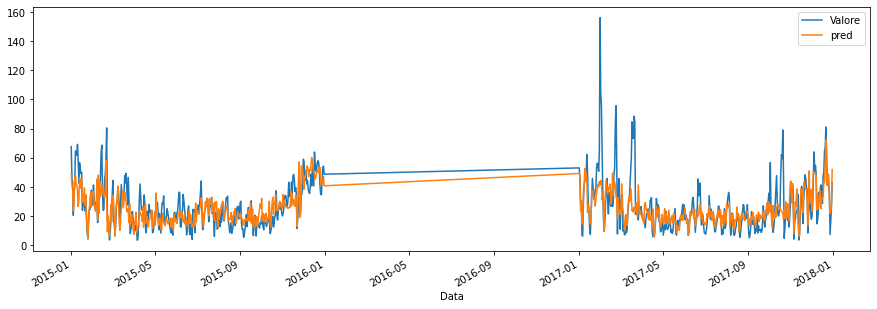

In [910]:
fig, ax = plt.subplots(figsize=(15, 5))
test_chart_data.plot("Data", "Valore", ax=ax)
test_chart_data.plot("Data", "pred", ax=ax)

(-5.0, 105.0)

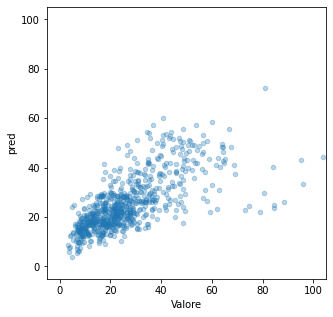

In [911]:
fig, ax = plt.subplots(figsize=(5, 5))
test_chart_data.plot.scatter("Valore", "pred", alpha=0.3, ax=ax)
# ax.set_xlim(-5, 165)
# ax.set_ylim(-5, 165)

ax.set_xlim(-5, 105)
ax.set_ylim(-5, 105)



In [912]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')

Mean absolute error: 7.91
Mean squared error: 148.84
Root mean squared error: 12.20


In [913]:
regressor.score(X_test, y_test)

0.45368197568679713

In [914]:
actual_minus_predicted = sum((y_test - y_pred)**2)
actual_minus_actual_mean = sum((y_test - y_test.mean())**2)
r2 = 1 - actual_minus_predicted/actual_minus_actual_mean
print('R²:', r2)

R²: 0.45368197568679736


# ---- START OF RANDOM FOREST ----

In [915]:
from sklearn.ensemble import RandomForestRegressor
SEED = 42

In [997]:
X_train.shape

(3090, 56)

In [1005]:
regressor = RandomForestRegressor(n_estimators = 100, random_state = SEED)
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [1006]:
score = regressor.score(X_train, y_train)
print("R2:", score)

R2: 0.9519664080117538


In [1007]:
y_pred = regressor.predict(X_test)

In [983]:
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(results)

         Actual  Predicted
1096  67.600000  48.505453
1097  45.666667  41.461304
1098  43.125000  38.350377
1099  20.500000  23.558485
1100  38.416667  28.020779
...         ...        ...
2187  37.083333  30.606212
2188   7.291667  21.736954
2189  16.666667  23.337951
2190  26.291667  28.010686
2191  42.875000  51.945166

[725 rows x 2 columns]


In [1008]:
results.corr()

,Actual,Predicted
Actual,1.000000,0.677465
Predicted,0.677465,1.000000


In [1009]:
test_chart_data = merged_df[
    merged_df.Data.dt.year.isin(test_years)
]
test_chart_data["pred"] = regressor.predict(test_chart_data[input_columns])

C:\Users\thoma\AppData\Local\Temp\ipykernel_3592\643691821.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_chart_data["pred"] = regressor.predict(test_chart_data[input_columns])


In [1010]:
X_train

,rain,temp,hum,w_dir,w_sp,press,sol,rain 1 day/s earlier,temp 1 day/s earlier,press 1 day/s earlier,...,w_dir 6 day/s earlier,w_sp 6 day/s earlier,sol 6 day/s earlier,rain 7 day/s earlier,temp 7 day/s earlier,press 7 day/s earlier,hum 7 day/s earlier,w_dir 7 day/s earlier,w_sp 7 day/s earlier,sol 7 day/s earlier
7,0.0,3.9,61.6,348.0,2.5,990.6,7850.6,0.0,1.5,991.4,...,348.0,1.0,1154.3,0.0,0.0,995.5,78.6,342.0,0.7,6433.5
8,0.0,3.5,60.6,330.0,1.5,997.2,7607.4,0.0,3.9,990.6,...,329.0,1.8,7082.0,15.0,-0.4,994.7,95.0,348.0,1.0,1154.3
9,0.0,4.1,56.8,349.0,1.9,1001.2,8116.0,0.0,3.5,997.2,...,337.0,1.0,3149.2,0.6,3.6,997.5,86.8,329.0,1.8,7082.0
10,0.0,2.1,65.6,342.0,0.8,1005.3,7614.8,0.0,4.1,1001.2,...,343.0,1.5,5839.9,0.0,0.1,993.7,90.0,337.0,1.0,3149.2
11,0.0,0.6,80.6,336.0,0.6,1001.4,7700.2,0.0,2.1,1005.3,...,333.0,3.0,7149.7,0.0,1.0,980.3,79.8,343.0,1.5,5839.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3837,7.0,23.2,70.6,315.0,3.7,991.4,16440.8,0.0,27.8,990.2,...,320.0,2.2,11866.2,0.0,27.5,988.2,52.8,273.0,2.3,25786.5
3838,0.0,24.9,59.5,330.0,2.9,989.0,25228.8,7.0,23.2,991.4,...,306.0,2.2,16878.8,1.8,23.6,988.5,68.1,320.0,2.2,11866.2
3839,0.0,25.2,54.2,336.0,2.0,990.8,28751.0,0.0,24.9,989.0,...,279.0,2.3,26393.4,3.6,23.0,985.2,74.3,306.0,2.2,16878.8
3840,4.0,23.5,62.2,296.0,1.3,989.6,19994.8,0.0,25.2,990.8,...,272.0,2.3,21259.8,0.0,25.5,985.1,63.0,279.0,2.3,26393.4


<AxesSubplot:xlabel='Data'>

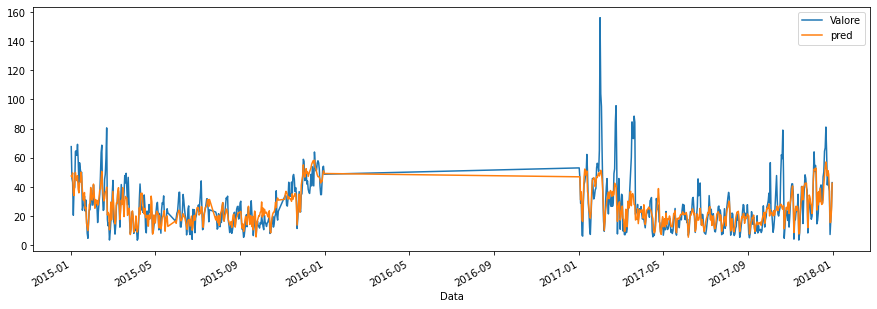

In [1011]:
fig, ax = plt.subplots(figsize=(15, 5))
test_chart_data.plot("Data", "Valore", ax=ax)
test_chart_data.plot("Data", "pred", ax=ax)

(-5.0, 105.0)

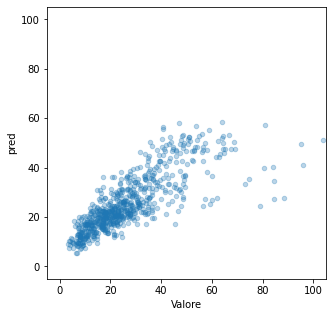

In [1012]:
fig, ax = plt.subplots(figsize=(5, 5))
test_chart_data.plot.scatter("Valore", "pred", alpha=0.3, ax=ax)
# ax.set_xlim(-5, 165)
# ax.set_ylim(-5, 165)

ax.set_xlim(-5, 105)
ax.set_ylim(-5, 105)

In [1013]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')

Mean absolute error: 6.51
Mean squared error: 112.79
Root mean squared error: 10.62


In [1014]:
regressor.score(X_test, y_test)

0.5938019910809613

In [1015]:
actual_minus_predicted = sum((y_test - y_pred)**2)
actual_minus_actual_mean = sum((y_test - y_test.mean())**2)
r2 = 1 - actual_minus_predicted/actual_minus_actual_mean
print('R²:', r2)

R²: 0.5938019910809607


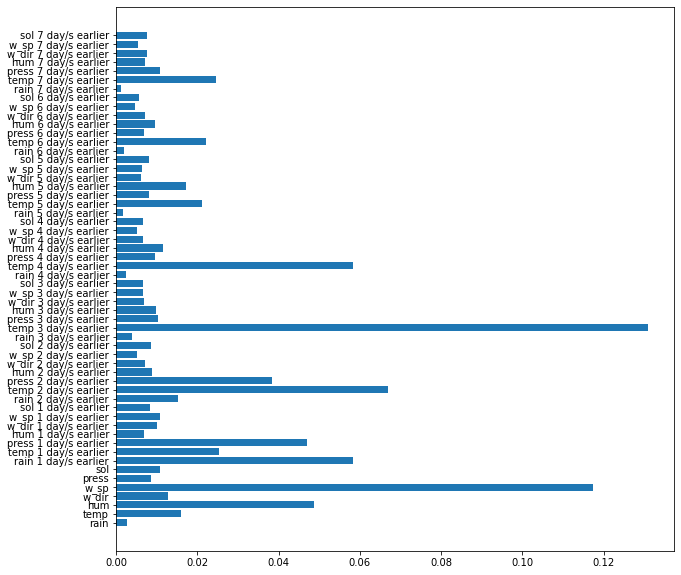

In [1016]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
ax.barh(X_test.columns, regressor.feature_importances_)
plt.show()

In [1019]:
input_columns[22]

'temp 3 day/s earlier'

In [ ]:
# number of pollutanpts for one station


In [1026]:
prev_val = test_chart_data.iloc[-365].Valore

predictions1 = []
predictions2 = []

for i, row in test_chart_data.iloc[-365:].iterrows():
    row_array = row[input_columns].to_numpy()

    result1 = regressor.predict([row_array])[0]  # takes the predicted value

    for i in range(8):
        row_array[1 + 7*i] += 5
    

    #row_array[-1] = prev_val
    result2 = regressor.predict([row_array])[0]  # takes the predicted value

        
    predictions1.append(result1)
    predictions2.append(result2)

c:\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegress

In [1021]:
# average_not_mod_df = np.array(predictions1).mean()
# print(average_not_mod_df)
# average_mod_df = np.array(predictions2).mean()
# print(average_mod_df)


data = {}

diff_df = pd.DataFrame(data)
diff_df["val1"] = predictions1
diff_df["val2"] = predictions2
#diff_df["diff"] = diff_df["val1"] - diff_df["val2"]

diff_df




,val1,val2
0,46.881807,47.071391
1,46.952976,46.530802
2,31.156435,30.062535
3,36.547775,34.445355
4,17.262038,16.865805
...,...,...
360,37.988169,37.070075
361,15.444450,15.287518
362,15.704174,15.747161
363,23.855558,23.646856


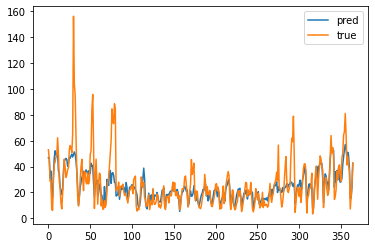

In [1027]:
# NOT modified values

plt.plot(predictions1, label ="pred")
plt.plot(test_chart_data.iloc[-365:].Valore.to_numpy(), label="true")
plt.legend()
plt.show()

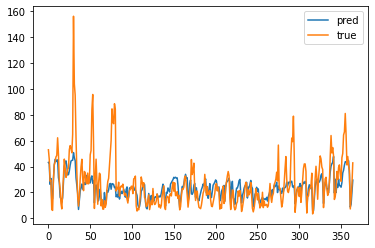

In [1028]:
# Changed values
plt.plot(predictions2, label ="pred")
plt.plot(test_chart_data.iloc[-365:].Valore.to_numpy(), label="true")
plt.legend()
plt.show()

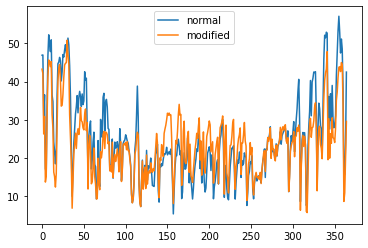

In [1029]:
# Difference between real values and modified vales

plt.plot(predictions1, label="normal")
plt.plot(predictions2, label ="modified")
plt.legend()
plt.show()

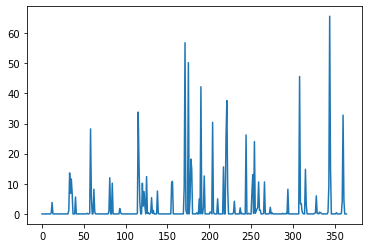

In [ ]:
# Plot of a certain value

plt.plot(test_chart_data.iloc[-365:]["rain"].to_numpy())
plt.show()


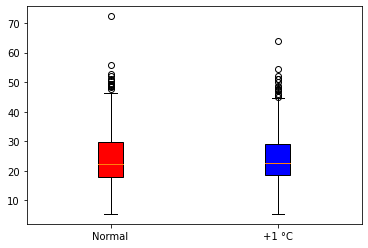

In [950]:
colors = ["red", "blue"]
bp = plt.boxplot(diff_df, patch_artist=True)
plt.xticks([1, 2], ['Normal', '+1 °C'])

for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
